# NN tryouts on SPR data, inspired by Kaggle Forum "When less is more"

Load training and validation data as 
    month : [ Features | Targets| Difference | Last Choice Targets  ]
    
    - Features : 
    - Target labels : TARGET_LABELS(month), 'targets_str', 'targets_dec'
    - Difference with prev month : diff' = targets_dec(month) - targets_dec(month-1)
    - Last Choice Targets : LC_TARGET_LABELS(month-1), 'lc_targets_str', 'lc_targets_dec'


In [1]:
import os
import numpy as np
import pandas as pd

import logging
logging.getLogger().handlers = []
logging.basicConfig(level=logging.INFO)

import matplotlib.pylab as plt
%matplotlib inline

In [337]:
from dataset import load_trainval, LC_TARGET_LABELS, decimal_to_dummies, targets_str_to_indices, targets_dec_to_indices
from common import to_yearmonth, TARGET_LABELS


# def targets_str_to_indices(targets_str):
#     out = []
#     for s in targets_str:
#         out.append([i for i, c in enumerate(s) if int(c) == 1])
#     return np.array(out)

# def targets_dec_to_indices(targets_dec):
#     out = []
#     for v in targets_dec:
#         print v, 
#         s = decimal_to_dummies(v)
#         print s, 
#         ind = [i for i, c in enumerate(s) if int(c) == 1]
#         out.append(ind)
#         print ind 
    
#     return np.array(out)  

In [3]:
features = [
    u'ind_empleado', u'pais_residencia',
    u'sexo', u'age', u'ind_nuevo', u'antiguedad', u'indrel',
    u'ult_fec_cli_1t', u'indrel_1mes', u'tiprel_1mes', u'indresi',
    u'indext', u'conyuemp', u'canal_entrada', u'indfall', u'nomprov',
    u'ind_actividad_cliente', u'renta', u'segmento'    
]

In [4]:
train_yearmonths_list = [201503, 201504, 201505, 201506, 201603, 201604]
#train_yearmonths_list = [201505, 201506, 201604]
val_yearmonth = [201605]
train_nb_clients = 50000
train_df, val_df = load_trainval(train_yearmonths_list, val_yearmonth, train_nb_clients)

INFO:root:- Load training data : [201502, 201503, 201504, 201505, 201506, 201602, 201603, 201604]
INFO:root:-- Select 50000 clients
INFO:root:- Number of lines with unknown data : 5
INFO:root:- Number of columns with nan : 9
INFO:root:-- Process date : 201503
/home/osboxes/Documents/TDS/venv/local/lib/python2.7/site-packages/pandas/core/indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/osboxes/Documents/TDS/venv/local/lib/python2.7/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

Display loaded data

In [5]:
print train_df.shape, train_df.columns

(399992, 75) Index([u'fecha_dato', u'ncodpers', u'ind_empleado', u'pais_residencia',
       u'sexo', u'age', u'fecha_alta', u'ind_nuevo', u'antiguedad', u'indrel',
       u'ult_fec_cli_1t', u'indrel_1mes', u'tiprel_1mes', u'indresi',
       u'indext', u'conyuemp', u'canal_entrada', u'indfall', u'nomprov',
       u'ind_actividad_cliente', u'renta', u'segmento', u'ind_ahor_fin_ult1',
       u'ind_aval_fin_ult1', u'ind_cco_fin_ult1', u'ind_cder_fin_ult1',
       u'ind_cno_fin_ult1', u'ind_ctju_fin_ult1', u'ind_ctma_fin_ult1',
       u'ind_ctop_fin_ult1', u'ind_ctpp_fin_ult1', u'ind_deco_fin_ult1',
       u'ind_deme_fin_ult1', u'ind_dela_fin_ult1', u'ind_ecue_fin_ult1',
       u'ind_fond_fin_ult1', u'ind_hip_fin_ult1', u'ind_plan_fin_ult1',
       u'ind_pres_fin_ult1', u'ind_reca_fin_ult1', u'ind_tjcr_fin_ult1',
       u'ind_valo_fin_ult1', u'ind_viv_fin_ult1', u'ind_nomina_ult1',
       u'ind_nom_pens_ult1', u'ind_recibo_ult1', u'targets_str',
       u'targets_dec', u'diff', u'lc_ind_ahor

In [6]:
print val_df.shape, val_df.columns

(1853326, 75) Index([u'fecha_dato', u'ncodpers', u'ind_empleado', u'pais_residencia',
       u'sexo', u'age', u'fecha_alta', u'ind_nuevo', u'antiguedad', u'indrel',
       u'ult_fec_cli_1t', u'indrel_1mes', u'tiprel_1mes', u'indresi',
       u'indext', u'conyuemp', u'canal_entrada', u'indfall', u'nomprov',
       u'ind_actividad_cliente', u'renta', u'segmento', u'ind_ahor_fin_ult1',
       u'ind_aval_fin_ult1', u'ind_cco_fin_ult1', u'ind_cder_fin_ult1',
       u'ind_cno_fin_ult1', u'ind_ctju_fin_ult1', u'ind_ctma_fin_ult1',
       u'ind_ctop_fin_ult1', u'ind_ctpp_fin_ult1', u'ind_deco_fin_ult1',
       u'ind_deme_fin_ult1', u'ind_dela_fin_ult1', u'ind_ecue_fin_ult1',
       u'ind_fond_fin_ult1', u'ind_hip_fin_ult1', u'ind_plan_fin_ult1',
       u'ind_pres_fin_ult1', u'ind_reca_fin_ult1', u'ind_tjcr_fin_ult1',
       u'ind_valo_fin_ult1', u'ind_viv_fin_ult1', u'ind_nomina_ult1',
       u'ind_nom_pens_ult1', u'ind_recibo_ult1', u'targets_str',
       u'targets_dec', u'diff', u'lc_ind_aho

In [7]:
#train_df.head(10)

In [8]:
mask = (~train_df['diff'].isin([0, -16777216]))
train_df[mask].sort_values(['ncodpers', 'fecha_dato'])[['fecha_dato', 'ncodpers', 'targets_str', 'targets_dec', 'diff', 'lc_targets_str', 'lc_targets_dec']].head(10)

,fecha_dato,ncodpers,targets_str,targets_dec,diff,lc_targets_str,lc_targets_dec
2308311,2015-05-28,15949,001000011000000101100001,2195809,1,001000011000000101100000,2195808.0
2940236,2015-06-28,15949,001000011000000101100000,2195808,-1,001000011000000101100001,2195809.0
1048458,2015-03-28,15950,001000000000000101100001,2097505,-65536,001000010000000101100001,2163041.0
4380281,2016-03-28,15950,000000000000000101000001,321,-32,000000000000000101100001,353.0
5430473,2016-04-28,15950,001000000000000101000001,2097473,2097152,000000000000000101000001,321.0
1048484,2015-03-28,15965,001000001001100101010001,2136401,-65568,001000011001100101110001,2201969.0
1466707,2015-04-28,15965,001000001001100101110001,2136433,32,001000001001100101010001,2136401.0
2308284,2015-05-28,15965,001000001001100101010001,2136401,-32,001000001001100101110001,2136433.0
4380241,2016-03-28,15965,001000011001100101010001,2201937,2162656,000000001001100101110001,39281.0
5430316,2016-04-28,15965,001000011001100101110001,2201969,32,001000011001100101010001,2201937.0


In [9]:
res = train_df['targets_dec'].apply(decimal_to_dummies)
assert (res.values == train_df['targets_str'].values).all(), "Problem with transformation of target labels"

In [12]:
#val_df.head(10)

In [11]:
#mask = (~val_df['diff'].isnull()) & (val_df['diff'] != 0.0)
#val_df[mask].sort_values(['ncodpers', 'fecha_dato'])[['fecha_dato', 'ncodpers', 'targets_str', 'targets_dec', 'diff', 'lc_targets_str', 'lc_targets_dec']].head(10)

,fecha_dato,ncodpers,targets_str,targets_dec,diff,lc_targets_str,lc_targets_dec
433431,2016-04-28,15889,001000001000000000010000,2129936,-16777216,NaN,NaN
1238761,2016-05-28,15889,001000001000000000110000,2129968,32,001000001000000000010000,2129936.0
433432,2016-04-28,15890,000010001000100100100111,559399,-16777216,NaN,NaN
433433,2016-04-28,15892,001000000001100001110001,2103409,-16777216,NaN,NaN
433462,2016-04-28,15893,000000000000000000010000,16,-16777216,NaN,NaN
433463,2016-04-28,15894,001000000000100001110111,2099319,-16777216,NaN,NaN
433464,2016-04-28,15895,001000000000100101110001,2099569,-16777216,NaN,NaN
433465,2016-04-28,15896,001000010000100000010000,2164752,-16777216,NaN,NaN
433466,2016-04-28,15897,000010010000110101110011,593267,-16777216,NaN,NaN
433467,2016-04-28,15898,000000000000000000000000,0,-16777216,NaN,NaN


In [13]:
res = val_df['targets_dec'].apply(decimal_to_dummies)
assert (res.values == val_df['targets_str'].values).all(), "Problem with transformation of target labels"

## Check active client performances 2015 -> 2016

1) We observed that client actions repeats from 2015 to 2016. For example, there are ~37% of clients that add the same products in 2015-MM and in 2016-MM and ~50% of clients that add or remove that same quantity of products in 2015-MM and 2016-MM.

In [14]:
def get_common_clients(df1, mask1, mask2, df2=None):
    active_clients1 = df1[mask1]['ncodpers'].unique()
    if df2 is not None:
        active_clients2 = df2[mask2]['ncodpers'].unique()
    else:
        active_clients2 = df1[mask2]['ncodpers'].unique()
    active_clients = list(set(active_clients1) & set(active_clients2)) 
    
    if df2 is not None:
        return df1['ncodpers'].isin(active_clients), df2['ncodpers'].isin(active_clients)
    return df1['ncodpers'].isin(active_clients)

In [15]:
months_ym_map = {}
months = list(set(train_df['fecha_dato'].unique()) | set(val_df['fecha_dato'].unique()))
for m in months:
    months_ym_map[to_yearmonth(m)] = m

In [16]:
yms = [201503, 201504, 201505]
#yms = [201505]

train_months = train_df['fecha_dato'].unique()
val_months = val_df['fecha_dato'].unique()
for ym in yms:
    ym1 = ym + 100
    
    df1 = train_df if months_ym_map[ym] in train_months else val_df
    df2 = train_df if months_ym_map[ym1] in train_months else val_df
    
    mask1 = (~df1['diff'].isnull()) & (df1['diff'] != 0.0)
    tmask1 = df1['fecha_dato'] == months_ym_map[ym]
    mask2 = (~df2['diff'].isnull()) & (df2['diff'] != 0.0)
    tmask2 = df2['fecha_dato'] == months_ym_map[ym1]
    
    active_clients_mask1, active_clients_mask2  = get_common_clients(df1, tmask1 & mask1, tmask2 & mask2, df2)
    
    mask1 &= active_clients_mask1
    t1 = df1[tmask1 & mask1].sort_values(['ncodpers', 'fecha_dato'])[['fecha_dato', 'ncodpers', 'targets_dec', 'diff', 'lc_targets_dec']]

    mask2 &= active_clients_mask2
    t2 = df2[tmask2 & mask2].sort_values(['ncodpers', 'fecha_dato'])[['fecha_dato', 'ncodpers', 'targets_dec', 'diff', 'lc_targets_dec']]

    print "-------"
    print ym, ym1
    total = t1['diff'].shape[0]
    eq = (t1['diff'].values == t2['diff'].values).sum()
    aeq = (np.abs(t1['diff'].values) == np.abs(t2['diff'].values)).sum()
    print "Percentage : eq =", eq*1.0/total, " | aeq =", aeq*1.0/total
    
       

-------
201503 201603
Percentage : eq = 0.349601593625  | aeq = 0.542828685259
-------
201504 201604
Percentage : eq = 0.385641025641  | aeq = 0.529230769231
-------
201505 201605
Percentage : eq = 0.36023054755  | aeq = 0.558117195005


In [21]:
mask1 = (~train_df['diff'].isnull()) & (train_df['diff'] != 0.0)
tmask1 = train_df['fecha_dato'] == '2015-05-28'

mask2 = (~val_df['diff'].isnull()) & (val_df['diff'] != 0.0)
tmask2 = val_df['fecha_dato'] == '2016-05-28'

active_clients_mask1, active_clients_mask2  = get_common_clients(train_df, tmask1 & mask1, tmask2 & mask2, val_df)

In [22]:
mask1 &= active_clients_mask1
t1 = train_df[tmask1 & mask1].sort_values(['ncodpers', 'fecha_dato'])[['fecha_dato', 'ncodpers', 'targets_dec', 'diff', 'lc_targets_dec']]
t1.head(10)

,fecha_dato,ncodpers,targets_dec,diff,lc_targets_dec
2308007,2015-05-28,16681,589894,-1,589895.0
2308984,2015-05-28,17958,524305,-2,524307.0
2308559,2015-05-28,18028,589894,-1,589895.0
2307580,2015-05-28,20658,530503,-32,530535.0
2307857,2015-05-28,20981,2099201,1,2099200.0
2310932,2015-05-28,22577,2129921,1,2129920.0
2310353,2015-05-28,23100,98336,-1,98337.0
2310492,2015-05-28,23522,2103296,-1,2103297.0
2309831,2015-05-28,28357,2162688,-1,2162689.0
2309961,2015-05-28,28734,592944,32,592912.0


In [23]:
mask2 &= active_clients_mask2
t2 = val_df[tmask2 & mask2].sort_values(['ncodpers', 'fecha_dato'])[['fecha_dato', 'ncodpers', 'targets_dec', 'diff', 'lc_targets_dec']]
t2.head(10)

,fecha_dato,ncodpers,targets_dec,diff,lc_targets_dec
1238609,2016-05-28,16681,589894,-1,589895.0
1237939,2016-05-28,17958,524305,-2,524307.0
1237640,2016-05-28,18028,589927,1,589926.0
1241076,2016-05-28,20658,530535,32,530503.0
1240914,2016-05-28,20981,2099201,1,2099200.0
1239876,2016-05-28,22577,2129921,1,2129920.0
1235132,2016-05-28,23100,98336,-1,98337.0
1234919,2016-05-28,23522,2103296,-1,2103297.0
1237522,2016-05-28,28357,2162689,1,2162688.0
1237095,2016-05-28,28734,593009,1,593008.0


In [24]:
total = t1['diff'].shape[0]
eq = (t1['diff'].values == t2['diff'].values).sum()
aeq = (np.abs(t1['diff'].values) == np.abs(t2['diff'].values)).sum()
print "Percentage : eq =", eq*1.0/total, " | aeq =", aeq*1.0/total


Percentage : eq = 0.36023054755  | aeq = 0.558117195005


Client who declare the 'renta' modifications -> nobody

In [25]:
train_months = train_df['fecha_dato'].unique()
val_months = val_df['fecha_dato'].unique()
for ym in yms:
    ym1 = ym + 100
    
    df1 = train_df if months_ym_map[ym] in train_months else val_df
    df2 = train_df if months_ym_map[ym1] in train_months else val_df
    
    tmask1 = df1['fecha_dato'] == months_ym_map[ym]
    tmask2 = df2['fecha_dato'] == months_ym_map[ym1]

    active_clients_mask1, active_clients_mask2 = get_common_clients(df1, tmask1, tmask2, df2)
    
    tmask1 &= active_clients_mask1
    r1 = df1[tmask1].sort_values(['ncodpers'])[['ncodpers', 'renta']]

    tmask2 &= active_clients_mask2
    r2 = df2[tmask2].sort_values(['ncodpers'])[['ncodpers', 'renta']]
    
    assert (r1['ncodpers'].values == r2['ncodpers'].values).all(), "WTF"
    rdiff = r1['renta'].values != r2['renta'].values
    print rdiff.sum()

0
0
0


2) Some clients buy/sell the same quantity of products in the time series: e.g. diff = [2, -2, 2, -2...]

In [26]:
mask = train_df['diff'].isin([2,-2])
train_df[mask].sort_values(['ncodpers', 'fecha_dato'])[['fecha_dato','ncodpers', 'renta', 'diff', 'targets_dec']].head(20)

,fecha_dato,ncodpers,renta,diff,targets_dec
1048604,2015-03-28,16563,151216.56,-2,527457
1466617,2015-04-28,16563,151216.56,2,527459
2308373,2015-05-28,16563,151216.56,-2,527457
2940434,2015-06-28,16563,151216.56,2,527459
1047966,2015-03-28,17483,74241.15,-2,526433
1466186,2015-04-28,17483,74241.15,2,526435
2308927,2015-05-28,17483,74241.15,-2,526433
2940923,2015-06-28,17483,74241.15,2,526435
1047782,2015-03-28,17958,17057.55,-2,524305
1466002,2015-04-28,17958,17057.55,2,524307


In [27]:
train_df[train_df['ncodpers']==23827][['fecha_dato','ncodpers', 'renta', 'diff', 'targets_dec', 'age'] + TARGET_LABELS].head(20)

,fecha_dato,ncodpers,renta,diff,targets_dec,age,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
207770,2015-02-28,23827,945487.65,-16777216,624739,71.0,0,0,0,0,...,0,0,0,1,1,0,0,0.0,1.0,1
1045505,2015-03-28,23827,945487.65,-2,624737,71.0,0,0,0,0,...,0,0,0,1,1,0,0,0.0,0.0,1
1463724,2015-04-28,23827,945487.65,2,624739,71.0,0,0,0,0,...,0,0,0,1,1,0,0,0.0,1.0,1
2311379,2015-05-28,23827,945487.65,-2,624737,71.0,0,0,0,0,...,0,0,0,1,1,0,0,0.0,0.0,1
2943432,2015-06-28,23827,945487.65,2,624739,71.0,0,0,0,0,...,0,0,0,1,1,0,0,0.0,1.0,1
3634064,2016-02-28,23827,945487.65,-16777216,624739,71.0,0,0,0,0,...,0,0,0,1,1,0,0,0.0,1.0,1
4376532,2016-03-28,23827,945487.65,0,624739,71.0,0,0,0,0,...,0,0,0,1,1,0,0,0.0,1.0,1
5424514,2016-04-28,23827,945487.65,0,624739,71.0,0,0,0,0,...,0,0,0,1,1,0,0,0.0,1.0,1


In [28]:
# yms = [201503, 201504, 201505, 201506]
# for i, ym in enumerate(yms[:-1]):
#     ym1 = yms[i+1]
    
#     df1 = train_df if months_ym_map[ym] in train_months else val_df
#     tmask1 = df1['fecha_dato'] == months_ym_map[ym]
#     tmask2 = df1['fecha_dato'] == months_ym_map[ym1]

#     print df1[tmask1][['ncodpers', 'diff']].head(3)
#     print df1[tmask2][['ncodpers', 'diff']].head(3)    
#     res = df1[tmask1]['diff'].values * df1[tmask2]['diff'].values < 0
#     print df1[tmask1]['diff'].shape, df1[tmask2]['diff'].shape, np.sum(res)
# #     print df1[res][['ncodpers', 'diff']].head(3)    

#     if i == 1: 
#         break
    
    

In [29]:
from common import get_added_products, remove_last_choice, apk, map7_score2
from visualization import visualize_train_test, visualize_folds, compare_two_datasets, compare_folds, compare_folds2

Create profiles and create models for profiles

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Merge
from keras.utils import np_utils

Using TensorFlow backend.


### Feature engineering

In [31]:
def get_age_group_index(age):
    if age < 10:
        return -3
    elif age < 15:
        return -2        
    elif age < 18:
        return -1    
    elif age < 23:
        return 0
    elif age < 25:
        return 1
    elif age < 27:
        return 2
    elif age < 28:
        return 3    
    elif age < 32:
        return 4
    elif age < 37:
        return 5    
    elif age < 42:
        return 6
    elif age < 47:
        return 7
    elif age < 52:
        return 8
    elif age < 57:
        return 9
    elif age < 60:
        return 10
    elif age < 65:
        return 11
    elif age < 70:
        return 12
    elif age < 75:
        return 13
    elif age < 80:
        return 14
    else:
        return 15

def get_income_group_index(income):
    if income < 0:
        return -1
    elif income < 45542.97:
        return 1
    elif income < 57629.67:
        return 2
    elif income < 68211.78:
        return 3
    elif income < 78852.39:
        return 4
    elif income < 90461.97:
        return 5
    elif income < 103855.23:
        return 6
    elif income < 120063.00:
        return 7
    elif income < 141347.49:
        return 8
    elif income < 173418.36:
        return 9
    elif income < 234687.12:
        return 10
    else:
        return 11

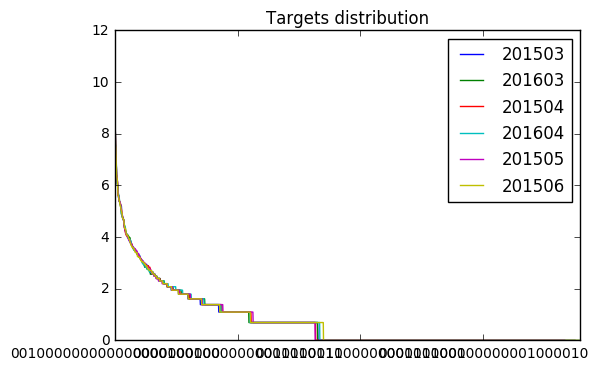

In [500]:
yms = [201503, 201504, 201505, 201506]

ll = len(yms)
plt.figure()
for i, ym in enumerate(yms):

    if months_ym_map[ym] in train_months:
        df1 = train_df 
        tmask1 = df1['fecha_dato'] == months_ym_map[ym] 
        plt.title("Targets distribution")
        df1[tmask1]['targets_str'].value_counts().apply(np.log).plot(label='%i' % ym)
    
    ym1 = ym + 100
    if ym1 in months_ym_map and months_ym_map[ym1] in train_months:
        df2 = train_df 
        tmask2 = df2['fecha_dato'] == months_ym_map[ym1]
        df2[tmask2]['targets_str'].value_counts().apply(np.log).plot(label='%i' % ym1)
    plt.legend()
    


In [501]:
DIST_DICT = train_df['targets_str'].value_counts().apply(np.log)

In [477]:
TARGETS_ENCODER_MAP = [{}, {}]

In [412]:
def targets_fit(encoder, data):
    logging.debug("-- Call targets_fit --")
        
    # initialize :
    if len(encoder[0]) == 0 :
        logging.debug("- Initialize targets encoder map")
        # fit :
        for i, v in enumerate(data):
            logging.debug("-1 Add : {} -> {}".format(v, i))
            encoder[0][v] = i
            encoder[1][i] = v # inverse

    # check :
    isin_mask = np.in1d(data, encoder[0].keys())
    logging.debug("- Check data")
    logging.debug("-- isin_mask: {}".format(isin_mask.all()))
    if not isin_mask.all():
        logging.debug("- Check is failed : need to add more")
        next_val = np.max(encoder[0].values()) + 1
        logging.debug("-- next_val: %i" % next_val)
        # fit :
        for i, v in enumerate(data[~isin_mask]):                
            logging.debug("-2 Add : {} -> {}".format(v, next_val + i))                
            encoder[0][v] = next_val + i  
            encoder[1][next_val + i] = v # inverse


def targets_transform(encoder, series):
    # transform :
    logging.debug("- Transform data")
    return series.apply(lambda x: encoder[0][x])


def targets_inv_transform(encoder, series):
    # transform :
    logging.debug("- Inverse Transform data")
    return series.apply(lambda x: encoder[1][x])



In [502]:
train_df2 = train_df.copy()

#targets_fit(TARGETS_ENCODER_MAP, train_df['targets_str'].value_counts().index.values)
#targets_fit(TARGETS_ENCODER_MAP, train_df['lc_targets_str_encoded'].value_counts().index.values)
#train_df2.loc[:, 'targets_str_encoded'] = targets_encode(TARGETS_ENCODER_MAP, train_df['targets_str'])
#train_df2.loc[clients_mask, 'lc_targets_str_encoded'] = targets_encode(TARGETS_ENCODER_MAP, train_df[clients_mask]['lc_targets_str'])

train_df2.loc[:, 'targets_logcount'] = train_df['targets_str'].apply(lambda x: DIST_DICT[x])

In [504]:
train_df2[clients_mask]['targets_logcount'].head(10)

1048508    1.609438
1466729    1.609438
2308279    1.609438
2940282    1.609438
4380287    1.098612
5430495    1.098612
1048459    1.791759
1466682    1.791759
2308311    2.302585
2940236    1.791759
Name: targets_logcount, dtype: float64

In [480]:
mask = train_df2[clients_mask]['dist'] != 0.0
train_df2[clients_mask & mask][['fecha_dato', 'ncodpers', 'targets_str', 'lc_targets_str', 'dist']].head(20)

/home/osboxes/Documents/TDS/venv/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


,fecha_dato,ncodpers,targets_str,lc_targets_str,dist
2308311,2015-05-28,15949,001000011000000101100001,001000011000000101100000,4.0
2940236,2015-06-28,15949,001000011000000101100000,001000011000000101100001,-4.0
1048458,2015-03-28,15950,001000000000000101100001,001000010000000101100001,5.0
1048484,2015-03-28,15965,001000001001100101010001,001000011001100101110001,2.0
1466707,2015-04-28,15965,001000001001100101110001,001000001001100101010001,-3.0
2308284,2015-05-28,15965,001000001001100101010001,001000001001100101110001,3.0
5430316,2016-04-28,15965,001000011001100101110001,001000011001100101010001,1.0
1466696,2015-04-28,15981,001000000000100101010001,001000000000110101010001,4.0
5430296,2016-04-28,16005,001000010000000000100001,001000010000000000100000,-236.0
1466594,2015-04-28,16196,000000011000100000100001,000010011000100000100001,-12.0


In [316]:
A = 1.0
B = 1.0
def transform_target(x):
    return np.sign(x) * np.log(np.abs(x) * 1.0 / A + B )

def inv_transform_target(y):
    return (np.sign(y)*(np.exp(np.abs(y)) - B) * A).astype(np.int)


#
# log(x / a + b) = y  ->  x/a = exp(y) - b
#
x = 2097457 
print transform_target(x), inv_transform_target(transform_target(x))

x_neg = np.arange(-16777216/2, 0, 1, dtype=np.int)
x_pos = np.arange(1, 16777216/2, 1, dtype=np.int)

diff = np.abs(inv_transform_target(transform_target(x_neg)) - x_neg)
mask = diff > 0

print x_neg[mask]
print inv_transform_target(transform_target(x_neg[mask]))


# print np.sum(diff), np.max(diff), diff
# diff = np.abs(inv_transform_target(transform_target(x_pos)) - x_pos)
# print np.sum(diff), np.max(diff), diff

14.5562366933 2097457
[-8388502 -8388501 -8388500 ...,       -7       -6       -4]
[-8388501 -8388500 -8388499 ...,       -6       -5       -3]


In [473]:
clients_mask = ~train_df2['diff'].isin([-16777216])

/home/osboxes/Documents/TDS/venv/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


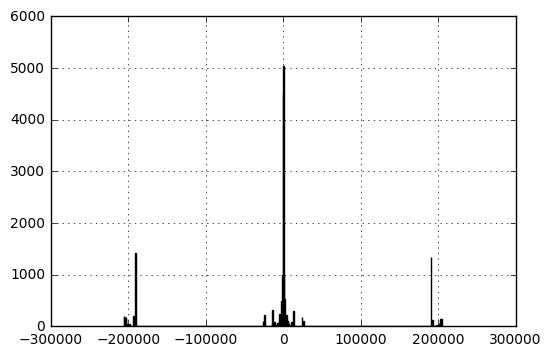

In [481]:
#train_df[clients_mask]['diff'].apply(transform_target).hist(bins=50)
train_df2[clients_mask & mask]['dist'].hist(bins=500)

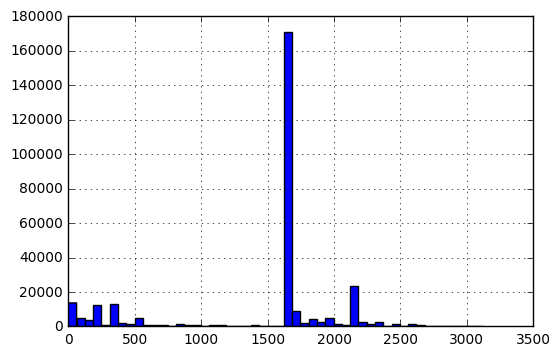

In [406]:
#train_df[clients_mask]['targets_dec'].apply(lambda x: x*1.0/(2**24)).hist(bins=50)
train_df2[clients_mask]['targets_str_encoded'].hist(bins=50)

In [294]:
train_fe_df = train_df.copy()
train_fe_df.loc[:,'age'] = train_df['age'].apply(get_age_group_index)
train_fe_df.loc[:,'renta'] = train_df['renta'].apply(get_income_group_index)
#rain_fe_df.loc[:,'diff'] = train_df[clients_mask]['diff'].apply(transform_target)
#rain_fe_df.loc[:,'targets_dec'] = train_df[clients_mask]['targets_dec'].apply(lambda x: x*1.0/(2**24))

In [295]:
train_fe_df[clients_mask][['age', 'renta', 'diff', 'targets_dec']].head()

,age,renta,diff,targets_dec
1048508,8,9,0,2337
1466729,8,9,0,2337
2308279,8,9,0,2337
2940282,8,9,0,2337
4380287,8,9,0,2097457


### Train a model

We can train over client features to predict products difference `diff`. 

``` python
for MM in ['04', '05']:
    X = [ Features | 'diff', abs('diff') ](2015-MM) #+ [ Diff Features ](2015-MM,2016-MM) 
    Y = [ 'diff', abs('diff') ](2016-MM)
    CrossVal()
```

In [125]:
active_clients_mask = ~train_df['diff'].isin([0, -16777216])

In [126]:
print active_clients_mask.shape, active_clients_mask.sum()

(399992,) 20348


In [127]:
current_month = 201503
next_year_month = current_month + 100
month_mask = train_df['fecha_dato'] == months_ym_map[current_month]
next_year_month_mask = train_df['fecha_dato'] == months_ym_map[next_year_month]

In [128]:
print (month_mask & active_clients_mask).shape, (month_mask & active_clients_mask).sum()
print (next_year_month_mask & active_clients_mask).shape, (next_year_month_mask & active_clients_mask).sum()

(399992,) 3480
(399992,) 3164


In [129]:
active_clients_mask2 = get_common_clients(train_df, month_mask & active_clients_mask, next_year_month_mask & active_clients_mask)

print active_clients_mask2.shape, active_clients_mask2.sum()
print (month_mask & active_clients_mask2).shape, (month_mask & active_clients_mask2).sum()
print (next_year_month_mask & active_clients_mask2).shape, (next_year_month_mask & active_clients_mask2).sum()

(399992,) 8032
(399992,) 1004
(399992,) 1004


In [207]:
X = train_fe_df[month_mask][['ncodpers', 'fecha_dato', 'diff', 'targets_dec'] + features]
Y = train_fe_df[next_year_month_mask][['ncodpers', 'fecha_dato', 'diff', 'targets_dec', 'lc_targets_dec'] + TARGET_LABELS]
clients_last_choice = train_fe_df[month_mask][['ncodpers', 'fecha_dato'] + LC_TARGET_LABELS]
clients_last_choice.columns = ['ncodpers', 'fecha_dato'] + TARGET_LABELS
assert (X['ncodpers'].values == Y['ncodpers'].values).all(), "There is a problem in alignment"
Y.index = X.index

In [208]:
print X.shape
X.head(10)

(49999, 23)


,ncodpers,fecha_dato,diff,targets_dec,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,...,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,nomprov,ind_actividad_cliente,renta,segmento
1048508,15913,2015-03-28,0.000000,2337,3,0,0,8,0,242,...,1,0,0,1,0,0,0,1.0,9,0
1048459,15949,2015-03-28,0.000000,2195808,1,0,1,8,0,242,...,1,0,0,1,0,0,0,1.0,10,0
1048458,15950,2015-03-28,-8.787922,2097505,0,0,0,11,0,242,...,1,0,0,1,0,0,0,1.0,9,0
1048484,15965,2015-03-28,-8.788410,2136401,3,0,1,8,0,242,...,1,0,0,1,0,0,0,1.0,1,1
1048481,15972,2015-03-28,0.000000,2097153,2,0,0,12,0,242,...,1,0,0,1,0,0,0,1.0,9,0
1048473,15981,2015-03-28,0.000000,2100561,1,0,0,8,0,242,...,1,0,0,1,0,0,0,1.0,11,0
1048568,16005,2015-03-28,0.000000,2162720,3,0,1,10,0,240,...,1,0,0,0,0,0,0,1.0,5,0
1048588,16040,2015-03-28,0.000000,2162977,3,0,1,8,0,241,...,1,0,0,0,0,0,0,1.0,7,0
1048544,16048,2015-03-28,0.000000,2097152,0,0,0,10,0,241,...,1,0,0,0,0,0,0,1.0,-1,0
1048564,16094,2015-03-28,0.000000,2097152,0,0,0,9,0,241,...,0,0,0,0,0,0,0,1.0,11,0


In [213]:
print Y.shape
Y.head(10)

(49999, 29)


,ncodpers,fecha_dato,diff,targets_dec,lc_targets_dec,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
1048508,15913,2016-03-28,0.000000,2097457,2097457.0,0,0,1,0,0,...,0,1,0,0,1,1,0,0.0,0.0,1
1048459,15949,2016-03-28,0.000000,2195809,2195809.0,0,0,1,0,0,...,0,1,0,1,1,0,0,0.0,0.0,1
1048458,15950,2016-03-28,-1.435085,321,353.0,0,0,0,0,0,...,0,1,0,1,0,0,0,0.0,0.0,1
1048484,15965,2016-03-28,12.284267,2201937,39281.0,0,0,1,0,0,...,0,1,0,1,0,1,0,0.0,0.0,1
1048481,15972,2016-03-28,0.000000,2097152,2097152.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
1048473,15981,2016-03-28,0.000000,2099537,2099537.0,0,0,1,0,0,...,0,1,0,1,0,1,0,0.0,0.0,1
1048568,16005,2016-03-28,0.000000,2162720,2162720.0,0,0,1,0,0,...,0,0,0,0,1,0,0,0.0,0.0,0
1048588,16040,2016-03-28,0.000000,2162977,2162977.0,0,0,1,0,0,...,0,1,0,0,1,0,0,0.0,0.0,1
1048544,16048,2016-03-28,0.000000,2097152,2097152.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
1048564,16094,2016-03-28,0.000000,2097152,2097152.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [203]:
print clients_last_choice.shape
clients_last_choice.head(10)

(49999, 26)


,ncodpers,fecha_dato,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
1048508,15913,2015-03-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1048459,15949,2015-03-28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1048458,15950,2015-03-28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1048484,15965,2015-03-28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
1048481,15972,2015-03-28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1048473,15981,2015-03-28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1048568,16005,2015-03-28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1048588,16040,2015-03-28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1048544,16048,2015-03-28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1048564,16094,2015-03-28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Run KFold Cross-validation 

In [163]:
def create_model(input_dim):
        
    model = Sequential()
    model.add(Dense(input_dim, init='uniform', input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.10))
    model.add(Dense(50, activation='relu', init='normal'))
    model.add(Dropout(0.10))
    model.add(Dense(30, activation='relu', init='normal'))
    model.add(Dropout(0.10))
    model.add(Dense(1, init='normal'))
    # for a mean squared error regression problem
    model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
    return model

In [220]:
x_profile = ['diff', 'targets_dec'] + features
y_profile = ['diff', 'lc_targets_dec'] + TARGET_LABELS

In [221]:
def map7_score2(y, y_pred, clients_last_choice):
    map7 = 0.0
    for last_choice, targets, products in zip(clients_last_choice, y, y_pred):
        added_products = get_added_products(targets, last_choice)
        predictions = remove_last_choice(products, last_choice)
        score = apk(added_products, predictions)    
        map7 += score            

    map7 /= len(y)
    logging.info('-- Predicted map7 score: {}'.format(map7))
    return map7

In [222]:
Y_PRED = None
Y_VAL = None

In [286]:
    #return [i for i, c in enumerate(target_str) if int(c) == 1]

#targets_str_to_indices = np.vectorize(target_str_to_indices)


def pred_to_targets(y_pred, last_target_dec):
    """
    y_pred is an ndarray of 'diff'
    last_target_dec is an ndarray of targets in decimal form of the last choice (previous month of predictions)
    :returns: ndarray of lists of product indices, e.g. [[1,2,3], [6], [], [23], ...]
    """
    if len(y_pred.shape) == 2:
        y_pred = np.reshape(y_pred, (y_pred.shape[0],))
    
    tmp1 = inv_transform_target(y_pred)
    targets_dec = tmp1 + last_target_dec
    targets_dec[targets_dec < 0] = 0
    targets_dec = targets_dec.astype(np.int)
    return targets_dec_to_indices(targets_dec)


print Y_VAL['diff'].values[0:4], inv_transform_target(Y_VAL['diff'].values)[0:4]

#print pred_to_targets(inv_transform_target(Y_PRED), Y_VAL['lc_targets_dec'].values)
#print pred_to_targets(inv_transform_target(Y_VAL['diff'].values), Y_VAL['lc_targets_dec'].values)
#print inv_transform_target(Y_VAL['diff'].values)
#print Y_VAL['lc_targets_dec'].values
 

[  0.           0.          -1.43508453  12.28426718] [  0.00000000e+00   0.00000000e+00  -3.20000000e+01   2.16265600e+06]


In [224]:
# CROSS VALIDATION
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
n_highest = 7


def prepare_to_fit(X_train, Y_train):
    # Select only active client for the training part
    mask = X_train['diff'] != 0.0
    x_train = X_train[mask].values
    y_train = Y_train[mask]['diff'].values
    # Probably should not scale 'diff'
    #x_train = StandardScaler().fit_transform(x_train)
    return x_train, y_train


def prepare_to_fit_nomask(X_train, Y_train):
    y_train = Y_train['diff'].values
    x_train = X_train.values
    # Probably should not scale 'diff'
    #x_train = StandardScaler().fit_transform(x_train)
    return x_train, y_train


def prepare_to_test(X_val, Y_val=None):
    if Y_val is not None:
        y_val = Y_val[TARGET_LABELS].values
    
    x_val = []
    x_val = X_val.values    
    # Probably should not scale 'diff'
    #x_val = StandardScaler().fit_transform(x_val)  
    
    if Y_val is not None:
        return x_val, y_val
    else:
        return x_val

    



def cross_val_score2(data, 
                     nb_folds=5, 
                     prepare_to_fit_func=prepare_to_fit, 
                     prepare_to_test_func=prepare_to_test,
                     transform_pred_func=pred_to_targets,
                     create_model_func=create_model):
    
    x_df, y_df, clients_last_choice_df = data
    kf = KFold(n_splits=nb_folds)
    scores = []
    
    for train_index, test_index in kf.split(range(x_df.shape[0])):
        X_train, X_val = x_df.loc[x_df.index[train_index], :], x_df.loc[x_df.index[test_index], :]
        Y_train, Y_val = y_df.loc[y_df.index[train_index], :], y_df.loc[y_df.index[test_index], :]
        CLC_val = clients_last_choice_df.loc[clients_last_choice_df.index[test_index], :]
                
        x_train, y_train = prepare_to_fit_func(X_train, Y_train)
        x_val, y_val = prepare_to_test_func(X_val, Y_val)
        
        logging.info("- Train/Val shapes : {}, {} | {}, {}".format(
                [i.shape for i in x_train] if isinstance(x_train, list) else x_train.shape, 
                [i.shape for i in x_val] if isinstance(x_val, list) else x_val.shape, 
                y_train.shape, 
                y_val.shape)
        )                
            
        logging.info("- Create the model : ")
        estimator = create_model_func(x_train.shape[1])
        logging.info("- Fit the model")
        hist = estimator.fit(x_train, y_train, nb_epoch=250, batch_size=5000, verbose=0)        
        for key in hist.history:            
            logging.info("-- %s : min=%f, max=%f" % (key, np.min(hist.history[key]), np.max(hist.history[key])))
        
        logging.info("- Predict using trained model")
        y_pred = estimator.predict(x_val, verbose=0)
    
        global Y_PRED, Y_VAL
        Y_PRED = y_pred
        Y_VAL = Y_val
        return 0
    
        y_pred = transform_pred_func(y_pred)
        logging.info("- Compute map7 score")
        scores.append(map7_score2(y_val, y_pred, CLC_val[TARGET_LABELS].values))        
    
    return np.array(scores)

In [225]:
nb_folds = 5
results = cross_val_score2((X[x_profile], Y[y_profile], clients_last_choice), 
                            #prepare_to_fit_func=prepare_to_fit,
                            nb_folds=nb_folds)
print "Cross-Validation \n %i | %f | %f | %f | %.5f " % (nb_folds, results.min(), results.mean(), results.max(), results.std())

INFO:root:- Train/Val shapes : (2460, 21), (10000, 21) | (2460,), (10000, 24)
INFO:root:- Create the model : 
INFO:root:- Fit the model
INFO:root:-- acc : min=0.059756, max=0.717886
INFO:root:-- loss : min=7.074025, max=108891.171875
INFO:root:- Predict using trained model


AttributeError: 'int' object has no attribute 'min'

### Test 1 : Train on active clients + feature engineering

#### Data: 

- train_yearmonths_list = [201503, 201504, 201505, 201506, 201603, 201604]
- val_yearmonth = [201605]
- train_nb_clients = 50000

#### Feature engineering

- age $rarrow-> age group
- income -> income group
- diff -> transform_target(diff)
- targets_dec -> targets_dec / $2^{24}$


#### Model

- 75 -> 50 -> 30 ->
- sigmoid, binary_crossentropy, nadam, accuracy, 

**Conf:**
- batch_size=2000

*Cross-validation results :* 

 Nb epoch | Nb folds | Min MAP@7 | Mean MAP@7 | Max MAP@7 | STD MAP@7
 --- | --- | --- | --- | --- | ---
 150 | 3 | 0.025659 | 0.029959 | 0.037639 | 0.00544 


#### Model 1 

- 50 -> 30 ->
- sigmoid, binary_crossentropy, nadam, accuracy, 

**Conf:**
- batch_size=2000

*Cross-validation results :* 

 Nb epoch | Nb folds | Min MAP@7 | Mean MAP@7 | Max MAP@7 | STD MAP@7
 --- | --- | --- | --- | --- | ---
 150 | 3 | 0.025802 | 0.030137 | 0.037217 | 0.00505 


Kaggle : 0.0197579

## Train model for predictions

In [ ]:
def train_model(X_train, Y_train):

    x_train, y_train = prepare_to_fit(X_train, Y_train)
    logging.info("- Train data shapes : {}, {}".format(
            [i.shape for i in x_train] if isinstance(x_train, list) else x_train.shape, 
            y_train.shape)
    )                

    logging.info("- Create the model")
    
    estimator = create_model(x_train.shape[1], len(TARGET_LABELS))
    logging.info("- Fit the model")
    hist = estimator.fit(x_train, y_train, nb_epoch=150, batch_size=2000, verbose=0)        
    for key in hist.history:            
        logging.info("-- %s : min=%f, max=%f" % (key, np.min(hist.history[key]), np.max(hist.history[key])))
    return estimator

estimator = train_model(X[['diff'] + features], Y)

Check score on the data 2016

In [ ]:
yearmonth_list = [201604, 201605] 
nb_months = len(yearmonth_list)
nb_clients = 'max'

In [ ]:
val_df = load_data2(TRAIN_FILE_PATH, yearmonth_list, nb_clients)
minimal_clean_data_inplace(val_df)
preprocess_data_inplace(val_df)

months = val_df['fecha_dato'].unique()
clients = val_df['ncodpers'].unique()
assert len(clients) == (val_df['ncodpers'].value_counts() == nb_months).sum()
ll = len(clients)
for m in months:
    l = len(val_df[val_df['fecha_dato'] == m]['ncodpers'].unique())
    assert l == ll, "Number of clients should be identical for all monthes. (%s, %s, %s)" % (m, l, ll)

In [ ]:
val_df = val_df.sort_values(['fecha_dato', 'ncodpers'])
last_choice_mask = val_df['fecha_dato'] == months[-2]
train_month_mask = trainval_df['fecha_dato'] == months[-1]

In [ ]:
def add_diff_inplace(df, last_choice_mask, train_month_mask):
    tmp_df = df[['fecha_dato','ncodpers']]
    tmp_df.loc[:,'target'] = df[TARGET_LABELS].sum(axis=1)
    v1 = tmp_df[train_month_mask]['target'].values
    v2 = tmp_df[last_choice_mask]['target'].values
    ll = min(len(v1), len(v2))
    indices = tmp_df.index[ll:]
    df.loc[indices,'diff'] = pd.Series(v1 - v2, index=indices)
    del tmp_df, v1, v2

In [ ]:
add_diff_inplace(trainval_df, last_choice_mask, train_month_mask)
print trainval_df.shape

In [ ]:
clients_last_choice = trainval_df[last_choice_mask][['ncodpers'] + TARGET_LABELS].sort_values(['ncodpers'])
X = trainval_df[train_month_mask][['ncodpers', 'diff'] + features]
Y = trainval_df[train_month_mask][['ncodpers'] + TARGET_LABELS]

In [ ]:
# Select only clients from test data
clients_last_choice = clients_last_choice[clients_last_choice['ncodpers'].isin(X['ncodpers'])]
assert (X['ncodpers'].values == clients_last_choice['ncodpers'].values).all(), "WTF"

## Prediction on test data

Load the last month from the training dataset to get user last choice and remove it from predictions

In [ ]:
yearmonth_list = [201605]
lastmonth_df = load_data2(TRAIN_FILE_PATH, yearmonth_list)
minimal_clean_data_inplace(lastmonth_df)

test_df = load_data2(TEST_FILE_PATH, [])
minimal_clean_data_inplace(test_df)
preprocess_data_inplace(test_df)
test_df = test_df.sort_values(['ncodpers'])

clients_last_choice_test = lastmonth_df[['ncodpers'] + TARGET_LABELS].sort_values(['ncodpers'])
# Select only clients from test data
clients_last_choice_test = clients_last_choice_test[clients_last_choice_test['ncodpers'].isin(test_df['ncodpers'])]
assert (test_df['ncodpers'].values == clients_last_choice_test['ncodpers'].values).all(), "WTF"

In [ ]:
X_test = test_df[['ncodpers'] + features]

In [ ]:
X_test.loc[:,'age'] = X_test['age'].apply(get_age_group_index)
X_test.loc[:,'renta'] = X_test['renta'].apply(get_income_group_index)

Make predictions

In [ ]:
def get_submission(y_pred, clients, clc, target_labels, n_highest=7):
    predicted_added_products = np.argsort(y_pred, axis=1)
    predicted_added_products = predicted_added_products[:,::-1][:,:n_highest]
    added_products_col = []
    count = 0 
    for products, last_choice in zip(predicted_added_products, clc):
        predictions = remove_last_choice(products, last_choice)
        added_products_col.append(' '.join([target_labels[i] for i in predictions]))
        count+=1
        if count % 100000 == 0:
            logging.info("Elapsed : %i", count)
            
    out = pd.DataFrame(data={'ncodpers': clients, 'added_products': added_products_col}, columns=['ncodpers', 'added_products'])
    return out

In [ ]:

data = {
    0: {'x': X_test, 'clc': clients_last_choice_test},
}

submissions = []
for i in data.keys():
    x = data[i]['x']
    clc = data[i]['clc']
    x_test = prepare_to_test(x)
    y_pred = estimator.predict(x_test, verbose=0)

    clients = x['ncodpers']
    submission = get_submission(y_pred, clients, clc[TARGET_LABELS].values, TARGET_LABELS, 7)
    print submission.head()
    submissions.append(submission)

submission = pd.concat(submissions)

In [ ]:
submission.head()

Get submission DataFrame and write csv file

In [ ]:
from datetime import datetime
import csv

logging.info('- Generate submission')
submission_file = '../results/submission_' + \
                  str(datetime.now().strftime("%Y-%m-%d-%H-%M")) + \
                  '.csv'

submission.to_csv(submission_file, index=False, index_label=False)